In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from typing import Tuple
import numpy as np
from PIL import Image
import urllib
import io

import torch
import torchvision.transforms as transforms

import timm
from timm.utils import AttentionExtract
timm.layers.set_fused_attn(False)
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [2]:
model = timm.create_model(
    "vit_large_patch14_reg4_dinov2.lvd142m",
    pretrained=True, num_classes=0,
    dynamic_img_size=True,
    img_size=448
).eval().cuda()

In [3]:
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model), is_training=False)

In [4]:
def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])

def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size

### official example

In [5]:
from timm.utils import AttentionExtract
timm.layers.set_fused_attn(False)

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
image = load_image_from_url(EXAMPLE_IMAGE_URL)

smaller_edge_size = 448
patch_size = model.patch_embed.patch_size[0]
image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)

extract = AttentionExtract(model, method='hook')

with torch.inference_mode():
    image_batch = image_tensor.cuda().unsqueeze(0)
    tokens = model.get_intermediate_layers(
        image_batch, n=1,
        norm=True
    )[0].squeeze()
    attns = extract(image_batch)

In [31]:
head_fusion = "mean"
discard_ratio = 0.2

result = torch.eye(attns[list(attns.keys())[0]].size(-1))
for _, attention in attns.items():
    if head_fusion == "mean":
        attention_heads_fused = attention.mean(axis=1)
    elif head_fusion == "max":
        attention_heads_fused = attention.max(axis=1)[0]
    elif head_fusion == "min":
        attention_heads_fused = attention.min(axis=1)[0]
    else:
        raise "Attention head fusion type Not supported"

    # Drop the lowest attentions, but
    # don't drop the class token
    # flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
    # _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
    # indices = indices[indices != 0]
    # flat[0, indices] = 0

    # I = torch.eye(attention_heads_fused.size(-1))
    # a = (attention_heads_fused.cpu() + 1.0 * I) / 2
    # a = a / a.sum(dim=-1)
    a = attention_heads_fused.clone().cpu()

    result = torch.matmul(a, result)

In [32]:
import cv2
from tqdm import tqdm

images_with_attn = []
for patch_ind in tqdm(range(32 * 42)):
    grid_size = (image_tensor.shape[-2] // patch_size, image_tensor.shape[-1] // patch_size)
    mask = result[0, patch_ind, model.num_prefix_tokens:].reshape(grid_size).numpy()
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    image_with_attn = (mask * image).astype("uint8")
    images_with_attn.append(image_with_attn)

100%|██████████| 1344/1344 [00:06<00:00, 219.48it/s]


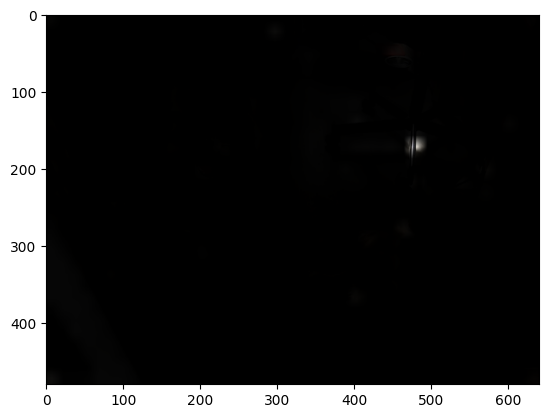

In [34]:
plt.imshow(images_with_attn[0])

In [27]:
import torch.nn as nn
import torch.nn.functional as F

original_h, original_w = image.size

patch_ind = -1
result = attns['blocks.22.attn.attn_drop'].sum(dim=1).squeeze()[patch_ind, model.num_prefix_tokens:].reshape(grid_size).cpu()
attention_of_image = F.interpolate(result.unsqueeze(0).unsqueeze(0), size=(original_h, original_w), mode='bilinear', align_corners=False).squeeze()
print(attention_of_image.shape)

torch.Size([640, 480])


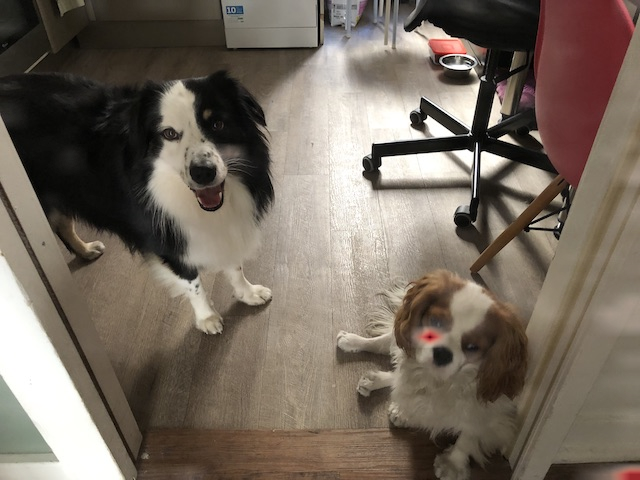

In [28]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline

image_metric = attention_of_image.numpy()
normalized_metric = Normalize(vmin=image_metric.min(), vmax=image_metric.max())(image_metric)

# Apply the Reds colormap
reds = plt.cm.Reds(normalized_metric)

# Create the alpha channel
alpha_max_value = 1.00  # Set your max alpha value
# Adjust this value as needed to enhance lower values visibility
gamma = 1.0
# Apply gamma transformation to enhance lower values
enhanced_metric = np.power(normalized_metric, gamma)
# Create the alpha channel with enhanced visibility for lower values
alpha_channel = enhanced_metric * alpha_max_value

# Add the alpha channel to the RGB data
rgba_mask = np.zeros((image_metric.shape[0], image_metric.shape[1], 4))
rgba_mask[..., :3] = reds[..., :3]  # RGB
rgba_mask[..., 3] = alpha_channel  # Alpha

# Convert the numpy array to PIL Image
rgba_image = Image.fromarray((rgba_mask.transpose(1, 0, 2) * 255).astype(np.uint8))

final_image = image.convert("RGBA")
final_image.paste(rgba_image, (0, 0), rgba_image)

final_image

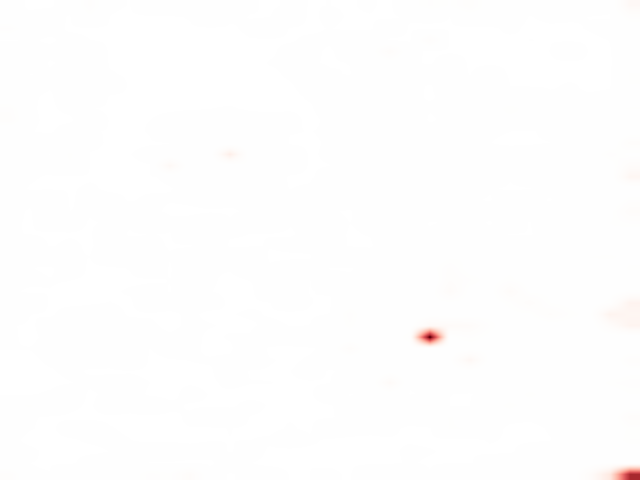

In [35]:
rgba_image

100%|██████████| 1344/1344 [00:07<00:00, 173.91it/s]


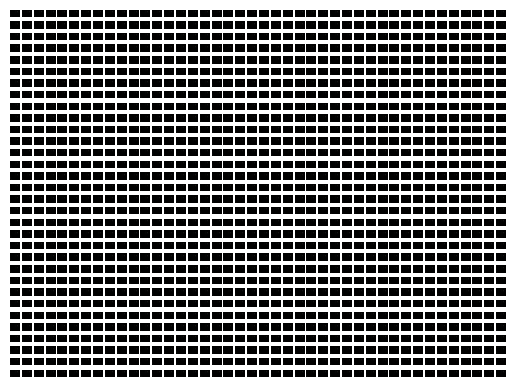

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, axes = plt.subplots(32, 42)
for patch_ind, ax in tqdm(zip(range(32 * 42), axes.flatten()), total=32 * 42):
    ax.imshow(image_with_attn)
    ax.axis("off")

# cur = result[0, patch_ind, model.num_prefix_tokens:].reshape(grid_size) / result[0, patch_ind].max()
# plt.imshow(cur, interpolation='nearest')

In [9]:
pind = 0
for i, (n, t) in enumerate(reversed(attns.items())):
    if i == 0:
        res = t.squeeze().clone()[:, pind + model.num_prefix_tokens, :]
    else:
        temp = t.squeeze().clone()[:, pind + model.num_prefix_tokens, :]
        res = temp * res

torch.Size([16, 1349])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')


In [12]:
model.num_prefix_tokens

5

In [25]:
attns['blocks.10.attn.attn_drop'][0][0][5:, 5].sum()

tensor(0.5533, device='cuda:0')

In [21]:
448 // 14, 588 // 14

(32, 42)

In [48]:
attns['blocks.10.attn.attn_drop'][0][0][5, :].sum()

tensor(1., device='cuda:0')

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import timm
import torch
from timm.utils import AttentionExtract
timm.layers.set_fused_attn(False)
mm = timm.create_model('vit_base_patch16_224')
input = torch.randn(2,3,224,224)
ee = AttentionExtract(mm, method='fx')
oo = ee(input)

In [ ]:
[0.5, 0.5]